## Carga de archivos

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

bank_additional = pd.read_csv("./datos_en_bruto/bank-additional.csv", sep = ',')
bank_additional.head()

customer_details_2012 = pd.read_excel('./datos_en_bruto/customer-details.xlsx', 
                         sheet_name = 0, 
                         header = 0)
customer_details_2012.head()

customer_details_2013 = pd.read_excel('./datos_en_bruto/customer-details.xlsx', 
                         sheet_name = 1, 
                         header = 0)
customer_details_2013.head()

customer_details_2014 = pd.read_excel('./datos_en_bruto/customer-details.xlsx', 
                         sheet_name = 2, 
                         header = 0)
customer_details_2014.head()

,Unnamed: 0,Income,Kidhome,Teenhome,Dt_Customer,NumWebVisitsMonth,ID
0,0,168812,1,1,2014-06-10,27,4d6c811c-0f24-4a73-b374-2ebd1f80d46e
1,1,108615,2,1,2014-04-05,24,eef0f24f-cbdb-4c67-b371-09d7bc59695e
2,2,179041,0,2,2014-09-22,4,bbfdcedd-199d-4927-94bb-5dad051ff471
3,3,116639,2,2,2014-08-16,3,e8ebb67d-4ee1-4615-b701-eefe3af607eb
4,4,49537,0,1,2014-09-05,28,f7f79ace-0024-4505-a401-f340946f0942


# Análisis exploratorio

En un primer vistazo de los datos vemos que tenemos dos archivos, customer-details.xlsx, vamos a comprobar que no haya datos que no necesitamos, nulos o duplicados que puedan interferir en el análisis

In [2]:
def separador():
    print("---------------------------------------------------")
# para conocer el número de filas y columnas
print(f"Filas y columnas: {bank_additional.shape}")

# para conocer la cantidad de datos
print(f"Datos: {bank_additional.size}")

# para conocer las columnas que tiene el archivo
print(f"Nombres de las columnas: {bank_additional.columns}")

# info general para saber si hay datos nulos o faltantes
separador()
print(bank_additional.info())

# para estar seguros, vemos que hay varias columnas con bastantes datos nulos, 
# por algún motivo no se han registrado en algunas de las interacciones con los clientes:
# age, job, marital, education, default, housing, loan, cons.price.idx, euribor3m, date
separador()
print(bank_additional.isnull().sum())

# buscamos filas duplicadas, y comprobamos que no hay
separador()
print(f"Filas duplicadas: {bank_additional.duplicated().sum()}")

# vamos a comprobar que en la columna id_ no haya duplicados, por si la podemos utilizar como índice más adelante
print(f"Ids duplicados: {bank_additional.duplicated('id_').sum()}")


Filas y columnas: (43000, 24)
Datos: 1032000
Nombres de las columnas: Index(['Unnamed: 0', 'age', 'job', 'marital', 'education', 'default',
       'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'date', 'latitude',
       'longitude', 'id_'],
      dtype='object')
---------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43000 entries, 0 to 42999
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      43000 non-null  int64  
 1   age             37880 non-null  float64
 2   job             42655 non-null  object 
 3   marital         42915 non-null  object 
 4   education       41193 non-null  object 
 5   default         34019 non-null  float64
 6   housing         41974 non-null  float64
 7   loan            41974 non-n

## Modificamos algunas columnas para trabajar con ellas más adelante

In [3]:
# renombramos la columna id_ a ID, para que oincidan en los dos archivos
bank_additional = bank_additional.rename(columns={"id_": "ID"})

# Modificamos el formato de algunas columnas a float para poder operar con ellas
cols_float = ['cons.price.idx', 'euribor3m', 'nr.employed']
bank_additional[cols_float] = bank_additional[cols_float].apply(
    lambda s: pd.to_numeric(s.astype(str).str.replace(',', '.', regex=False), errors='coerce')
)

# Modificamos la fecha:
# 1. Diccionario de meses en español → número
meses = {
    'enero': '01', 'febrero': '02', 'marzo': '03', 'abril': '04',
    'mayo': '05', 'junio': '06', 'julio': '07', 'agosto': '08',
    'septiembre': '09', 'octubre': '10', 'noviembre': '11', 'diciembre': '12'
}

# 2. Separar la columna date en tres partes: día, mes, año
tmp = bank_additional['date'].str.split('-', expand=True)
tmp.columns = ['day', 'month_name', 'year']

# 3. Convertir el nombre del mes a número
tmp['month_num'] = tmp['month_name'].str.lower().map(meses)

# 4. Construir una fecha tipo dd-mm-YYYY y convertir a datetime
bank_additional['date'] = pd.to_datetime(
    tmp['day'] + '-' + tmp['month_num'] + '-' + tmp['year'],
    format='%d-%m-%Y'
)

bank_additional['weekday'] = bank_additional['date'].dt.day_name()


##### Las columnas contact_month y contact_year que aparecen en el doc de word, no se encuentran en el excel, en su lugar, tenemos latitude y longitude

In [4]:
# vamos a empezar a comprobar que los datos sean correctos, 
# que no haya datos que sean lo mismo pero escrito diferente

print(f"Job: {bank_additional['job'].unique()}\n")
print(f"Marital: {bank_additional['marital'].unique()}\n")
print(f"Education: {bank_additional['education'].unique()}\n")
print(f"Default: {bank_additional['default'].unique()}\n") # Incumplimiento de pagos
print(f"Housing: {bank_additional['housing'].unique()}\n") # Préstamos hipotecario
print(f"Loan: {bank_additional['loan'].unique()}\n") # Algún otro préstamo
print(f"Contact: {bank_additional['contact'].unique()}\n") # Método de contacto para comunicarse con el cliente
# print(f"Duration: {bank_additional['duration'].unique()}\n")
# bank_additional['pdays'].unique()
# bank_additional['previous'].unique()
print(f"Previuos: {bank_additional['poutcome'].unique()}\n") # Resultados campaña anterior
# bank_additional['emp.var.rate'].unique()
# bank_additional['cons.price.idx'].unique()
# bank_additional['cons.conf.idx'].unique()
# bank_additional['euribor3m'].unique()
# bank_additional['nr.employed'].unique()
print(f"y: {bank_additional['y'].unique()}") # Resultado campaña actual
# bank_additional['date'].unique()
# print(f"Contact_month: {bank_additional['contact_month'].unique()}\n")
# bank_additional['latitude'].unique()
# bank_additional['longitude'].unique()
# bank_additional['ID'].unique()

Job: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' nan 'entrepreneur' 'student']

Marital: ['MARRIED' 'SINGLE' 'DIVORCED' nan]

Education: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course' nan
 'university.degree' 'illiterate']

Default: [ 0. nan  1.]

Housing: [ 0.  1. nan]

Loan: [ 0.  1. nan]

Contact: ['telephone' 'cellular']

Previuos: ['NONEXISTENT' 'FAILURE' 'SUCCESS']

y: ['no' 'yes']


#### Las variables **latitude** y **longitude** no parecen representar ubicaciones reales de clientes (los puntos forman un rectángulo regular que incluye zonas marítimas). Por ello, no se ha realizado un análisis geográfico detallado y estas variables solo se usan, en todo caso, como referencia muy aproximada del área (Norteamérica).

(El archivo **mapa_clientes.html** que se puede abrir en un navegador para su comprobación)

In [4]:
# Vamos a visualizar estas dos columnas para comprender los datos:
import folium

# Crear mapa centrado en Portugal
m = folium.Map(location=[20, 0], zoom_start=4)

# Añadir puntos
for _, row in bank_additional.iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']], radius=2).add_to(m)

m.save("mapa_clientes.html")

# Eliminamos las columnas ya que no van a ser necesarias para el análisis
bank_additional.drop(columns=['latitude', 'longitude'], inplace=True)

## Análisis Descriptivo

In [5]:
print(f"Resultados campaña anterior: \n{bank_additional.groupby('poutcome')['ID'].count().reset_index(name='n').sort_values('n', ascending=False).assign(pct=lambda d: d['n'] / d['n'].sum() * 100).round(2)}\n\n")
print(f"Resultados última anterior: \n{bank_additional.groupby('y')['ID'].count().reset_index(name='n').sort_values('n', ascending=False).assign(pct=lambda d: d['n'] / d['n'].sum() * 100).round(2)}")

Resultados campaña anterior: 
      poutcome      n    pct
1  NONEXISTENT  37103  86.29
0      FAILURE   4461  10.37
2      SUCCESS   1436   3.34


Resultados última anterior: 
     y      n    pct
0   no  38156  88.73
1  yes   4844  11.27


## Análisis demográfico básico
#### Vamos a analizar el perfil del cliente

In [6]:
# Grupos de edades frecuentes entre los clientes

# creamos la función de rango de edades que nos interese
def categorizar_edad (numero):
    """
    Función para categorizar edades.

    Parámetros:
    - numero (int): Número que se va a categorizar.

    Retorna:
    - str: Categoría a la que pertenece la edad.
    """
    if numero < 18:
        return '<18'
    elif 18 <= numero <= 28:
        return '18-28'
    elif 29 <= numero <= 64:
        return '29-64'
    else:
        return '>65'
    
# y añadimos una nueva columna con la edad categorizada
bank_additional['age_category'] = bank_additional['age'].apply(categorizar_edad)

# podemos observar que la mayoría de nuestros clientes son adultos en edad laboral, con la excepción de 5 jóvenes
print(f"Media de edad: {bank_additional['age'].mean()}\n")

# Categorías de edad
# podemos observar que la mayoría de nuestros clientes son adultos en edad laboral, con la excepción de 5 jóvenes
# menores de 18 y casi 4000 de entre 18 y 28, y 5736 de más de 65
separador()
print(f"Clientes según la edad: \n{bank_additional.groupby('age_category')['ID'].count().reset_index(name='n').sort_values('n', ascending=False).assign(pct=lambda d: d['n'] / d['n'].sum() * 100).round(2)}\n")


# Cantidad de clientes según el job
separador()
print("Clientes según el job:")
res = (
    bank_additional
      .query('age_category == "29-64"')
      .groupby('job', as_index=False)['ID'].count()
      .rename(columns={'ID': 'n'})
      .assign(pct=lambda d: d['n'] / d['n'].sum() * 100)
      .sort_values('n', ascending=False)
)

res['pct'] = res['pct'].round(2)
print(res)

# dentro de la categoría de adultos entre 29-64 años, la mayoría son admin
job_cat = bank_additional.query('age_category == "29-64"').groupby('job')['ID'].count().reset_index(name='n').sort_values('n', ascending=False).assign(pct=lambda d: d['n'] / d['n'].sum() * 100).round(2)
separador()
print(f"Job dentro de la categoría entre 29-64 años: \n{job_cat}")

# estado marital:
separador()
bank_additional.groupby('marital')['ID'].size().reset_index(name='n').sort_values('n', ascending=False).assign(pct=lambda d: d['n'] / d['n'].sum() * 100)

Media de edad: 39.97711193241816

---------------------------------------------------
Clientes según la edad: 
  age_category      n    pct
1        29-64  33348  77.55
3          >65   5736  13.34
0        18-28   3911   9.10
2          <18      5   0.01

---------------------------------------------------
Clientes según el job:
              job     n    pct
0          admin.  8548  25.84
1     blue-collar  7644  23.11
9      technician  5732  17.33
7        services  3112   9.41
4      management  2577   7.79
2    entrepreneur  1292   3.91
6   self-employed  1165   3.52
5         retired  1057   3.20
3       housemaid   917   2.77
10     unemployed   838   2.53
8         student   197   0.60
---------------------------------------------------
Job dentro de la categoría entre 29-64 años: 
              job     n    pct
0          admin.  8548  25.84
1     blue-collar  7644  23.11
9      technician  5732  17.33
7        services  3112   9.41
4      management  2577   7.79
2    entrepr

,marital,n,pct
1,MARRIED,25999,60.582547
2,SINGLE,12105,28.206921
0,DIVORCED,4811,11.210532


## Análisis cliente-resultado campaña
#### Vamos a analizar el perfil del cliente

In [7]:
def perfil_cliente_yes(option):
    return bank_additional.query('y == "yes"').groupby(['y', option])['ID'].size().reset_index(name='n').assign(pct=lambda d: d['n'] / d['n'].sum() * 100).round(2).sort_values('n', ascending=False)

# análisis de la edad del cliente ha contratado algo gracias a la campaña
edad2 = perfil_cliente_yes('age_category')
print(f"Edad: \n{edad2}")

# análisis del job del cliente que ha contratado algo gracias a la campaña
separador()
job2 = perfil_cliente_yes('job')
print(f"Job: \n{job2}")

# análisis del estado marital del cliente que ha contratado algo gracias a la campaña
separador()
marital2 = perfil_cliente_yes('marital')
print(f"Marital: \n{marital2}")

# análisis de la educación del cliente que ha contratado algo gracias a la campaña
education2 = perfil_cliente_yes('education')
separador()
print(f"Education: \n{education2}")



Edad: 
     y age_category     n    pct
1  yes        29-64  3297  68.06
3  yes          >65   863  17.82
0  yes        18-28   682  14.08
2  yes          <18     2   0.04
---------------------------------------------------
Job: 
      y            job     n    pct
0   yes         admin.  1415  29.45
9   yes     technician   762  15.86
1   yes    blue-collar   665  13.84
5   yes        retired   451   9.39
4   yes     management   342   7.12
7   yes       services   336   6.99
8   yes        student   283   5.89
6   yes  self-employed   161   3.35
10  yes     unemployed   153   3.18
2   yes   entrepreneur   126   2.62
3   yes      housemaid   111   2.31
---------------------------------------------------
Marital: 
     y   marital     n    pct
1  yes   MARRIED  2655  54.96
2  yes    SINGLE  1686  34.90
0  yes  DIVORCED   490  10.14
---------------------------------------------------
Education: 
     y            education     n    pct
6  yes    university.degree  1748  38.14
3  yes    

## Análisis LLamadas

In [8]:
# Media de la cantidad de segundos que ha durado la llamada
duracion = bank_additional.groupby(['y'])['duration'].mean().round(2).reset_index()
print(f"Duración: \n{duracion}\n")

# Media del número de veces que se ha contactado con el cliente
separador()
n_veces = bank_additional.groupby(['y'])['campaign'].mean().round(2).reset_index()
print(f"N veces: \n{n_veces}")

Duración: 
     y  duration
0   no    220.43
1  yes    551.62

---------------------------------------------------
N veces: 
     y  campaign
0   no      2.63
1  yes      2.05


## Análisis Macroeconómico

In [9]:
# emp.var.rate es la tasa de variación de empleo, es decir, cuánto ha cambiado el empleo respecto al trimestre anterior
# Hay una clara diferencia, cuando el empleo cae, los productos de la empresa se venden mejor
emp_var_rate = bank_additional.groupby('y')['emp.var.rate'].mean().round(2)
print(f"emp.var.rate: \n{emp_var_rate}\n")

# cons.price.idx es el Índice de Precios al Consumidor (IPC), No hay una diferencia relevante, 
# es de apenas 0,25 puntos entre los clientes que contrataron y los que no
separador()
cons_price_ipx =  bank_additional.groupby('y')['cons.price.idx'].mean().round(2)
print(f"cons.price.ipx: \n{cons_price_ipx}\n")

# euribor3m: En general los clientes que contrataron algún producto, tienen una media menos de 
# euribor que los que dijeron que no. Con el euribor bajo, las campañas son más efectivas.
separador()
euribor3m =  bank_additional.groupby('y')['euribor3m'].mean().round(2)
print(f"euribor3m: \n{euribor3m}\n")

# nr.employed: Número promedio de empleados (en el país) 
# los clientes que dijeron Sí fueron contactados cuando había menos empleo en el país.
separador()
nr_employed =  bank_additional.groupby('y')['nr.employed'].mean().round(2)
print(f"nr.employed: \n{nr_employed}\n")


# Conclusión:
# euribor3m bajo → crisis económica → la gente busca inversiones seguras.
# nr.employed bajo → más desempleo → mayor aversión al riesgo → más aceptación de productos bancarios conservadores.

emp.var.rate: 
y
no     0.24
yes   -1.24
Name: emp.var.rate, dtype: float64

---------------------------------------------------
cons.price.ipx: 
y
no     93.60
yes    93.35
Name: cons.price.idx, dtype: float64

---------------------------------------------------
euribor3m: 
y
no     3.81
yes    2.11
Name: euribor3m, dtype: float64

---------------------------------------------------
nr.employed: 
y
no     5176.03
yes    5094.54
Name: nr.employed, dtype: float64



## Análisis Fecha
#### ¿hay meses o años con más éxito en las campañas?

In [10]:
bank_additional['date'].dtype

dtype('<M8[ns]')

In [11]:
pd.set_option('display.max_rows', 500)
# Porcentaje de clientes que dijeron sí o no en los años que se realizó la campaña
year = bank_additional.groupby(bank_additional['date'].dt.year)['y'].value_counts(normalize=True).mul(100).round(2).reset_index()
print(f"Años: \n{year}\n")

# Porcentaje de clientes que dijeron sí o no en los meses que se realizó la campaña
month = bank_additional.groupby(bank_additional['date'].dt.month)['y'].value_counts(normalize=True).mul(100).round(2).reset_index()
separador()
print(f"Meses: \n{month}\n")

# Porcentaje de clientes que dijeron sí o no en los días del mes que se realizó la campaña
day = bank_additional.groupby(bank_additional['date'].dt.day)['y'].value_counts(normalize=True).mul(100).round(2).reset_index()
separador()
print(f"Días: \n{day}\n")

# Porcentaje de clientes que dijeron sí o no en los días del mes que se realizó la campaña, aquí podemos observar una ligera
# ventaja de los jueves para la campaña
# Lunes y viernes los menos favorables: Posible explicación: los lunes la gente suele estar ocupada o de mal humor, y los viernes pensando en el fin de semana.
weekday = bank_additional.groupby('weekday')['y'].value_counts(normalize=True).mul(100).round(2).reset_index()
separador()
print(f"Días de la semana: \n{weekday}\n")

Años: 
     date    y  proportion
0  2015.0   no       89.13
1  2015.0  yes       10.87
2  2016.0   no       88.32
3  2016.0  yes       11.68
4  2017.0   no       89.03
5  2017.0  yes       10.97
6  2018.0   no       88.55
7  2018.0  yes       11.45
8  2019.0   no       88.71
9  2019.0  yes       11.29

---------------------------------------------------
Meses: 
    date    y  proportion
0    1.0   no       88.40
1    1.0  yes       11.60
2    2.0   no       88.87
3    2.0  yes       11.13
4    3.0   no       89.27
5    3.0  yes       10.73
6    4.0   no       88.81
7    4.0  yes       11.19
8    5.0   no       89.37
9    5.0  yes       10.63
10   6.0   no       88.67
11   6.0  yes       11.33
12   7.0   no       88.59
13   7.0  yes       11.41
14   8.0   no       88.54
15   8.0  yes       11.46
16   9.0   no       89.75
17   9.0  yes       10.25
18  10.0   no       87.64
19  10.0  yes       12.36
20  11.0   no       88.51
21  11.0  yes       11.49
22  12.0   no       88.55
23  12.0  y

## Cruce con datos del cliente

In [12]:
# Añadimos una columna opcional para saber de qué año viene cada hoja
customer_details_2012['Year'] = 2012
customer_details_2013['Year'] = 2013
customer_details_2014['Year'] = 2014

# Unimos todo en un solo DataFrame
customer_details = pd.concat(
    [customer_details_2012, customer_details_2013, customer_details_2014],
    ignore_index=True
)

customer_details.head()
customer_details.shape

# Aseguramos mismo tipo de dato en la clave
bank_additional['ID'] = bank_additional['ID'].astype(str)
customer_details['ID'] = customer_details['ID'].astype(str)

# Unimos campaña + info de cliente
merged = bank_additional.merge(customer_details, on='ID', how='inner')

merged.shape
merged.head()

print("Registros en bank_additional:", len(bank_additional))
print("Registros en customer_details:", len(customer_details))
print("Registros tras el merge:", len(merged))

merged['children'] = merged['Kidhome'] + merged['Teenhome']


Registros en bank_additional: 43000
Registros en customer_details: 43170
Registros tras el merge: 43000


## Ingresos clientes
#### ¿Afecta a la contratación de algún producto?

In [13]:
# El nivel de ingresos parece no influir en la contratación de productos
nivel_ingresos = merged.groupby('y')['Income'].agg(['count', 'mean', 'median']).round(2)
print(f"Nivel de ingresos: \n {nivel_ingresos}\n")

# Historial de incumplimiento de pagos
merged.groupby(['default', 'y']).value_counts(normalize=True).mul(100).round(2).reset_index()
bank_additional['default'].value_counts(dropna=False)

bank_additional['default'] = bank_additional['default'].fillna('unknown')

default_y = (
    bank_additional
    .groupby('default')['y']
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .reset_index(name='proportion')
    .sort_values(['default', 'y'])
    .reset_index(drop=True)
)

# no hay evidencia de que la ausencia de default influya en la contratación de productos.
# El valor NaN (desconocido) representa casi el 21 % de los registros (8981 de 42000 aprox), 
# podría significar que el banco no tenía información crediticia de esos clientes
print(f"Historico de incumplimientos: \n{default_y}")


Nivel de ingresos: 
      count     mean   median
y                           
no   38156  93324.6  93206.5
yes   4844  92584.3  92144.5

Historico de incumplimientos: 
   default    y  proportion
0      0.0   no       87.14
1      0.0  yes       12.86
2      1.0   no      100.00
3  unknown   no       94.79
4  unknown  yes        5.21


## Tamaño del hogar

In [14]:
# ¿Influye el tamaño del hogar en la contratación de algún producto?
children_conv = (
    merged
    .groupby('children')['y']
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .reset_index(name='percentage')
)

print(f"Tamaño del hogar: \n{children_conv}")


Tamaño del hogar: 
   children    y  percentage
0         0   no       88.26
1         0  yes       11.74
2         1   no       89.20
3         1  yes       10.80
4         2   no       88.47
5         2  yes       11.53
6         3   no       88.98
7         3  yes       11.02
8         4   no       88.55
9         4  yes       11.45


## Antigüedad del cliente
#### ¿Influye la antigüedad del cliente?
En este caso podemos 

In [15]:
# Calculamos la antigüedad del cliente en una nueva columna
merged['customer_years'] = (merged['date'] - merged['Dt_Customer']).dt.days / 365.25
# Los clientes más recientes son algo más propensos a contratar un nuevo producto que los antiguos.
merged.groupby('y')['customer_years'].agg(['count', 'mean', 'median']).round(2)



,count,mean,median
y,,,
no,37941,4.21,4.22
yes,4811,3.55,3.53


## Comportamiento en la web
#### ¿Influye la cantidad de veces que el cliente visita la web?

In [16]:
merged.groupby('y')['NumWebVisitsMonth'].agg(['count', 'mean', 'median']).round(2)

,count,mean,median
y,,,
no,38156,16.59,17.0
yes,4844,16.60,17.0


## Guardamos el archivo final

In [17]:
merged.to_csv('./datos_transformados/merged.csv', index=False)

## Generación de gráficos
#### Vamos a usar seaborn encima de matplotlib porque para análisis exploratorio es más cómodo
Hay que instalar !pip install seaborn

In [19]:
!pip install seaborn

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# Estilo general bonito
sns.set(style="whitegrid")

# Para que los gráficos salgan dentro del notebook
%matplotlib inline

colors = ['#858DFF','#FAA30A']

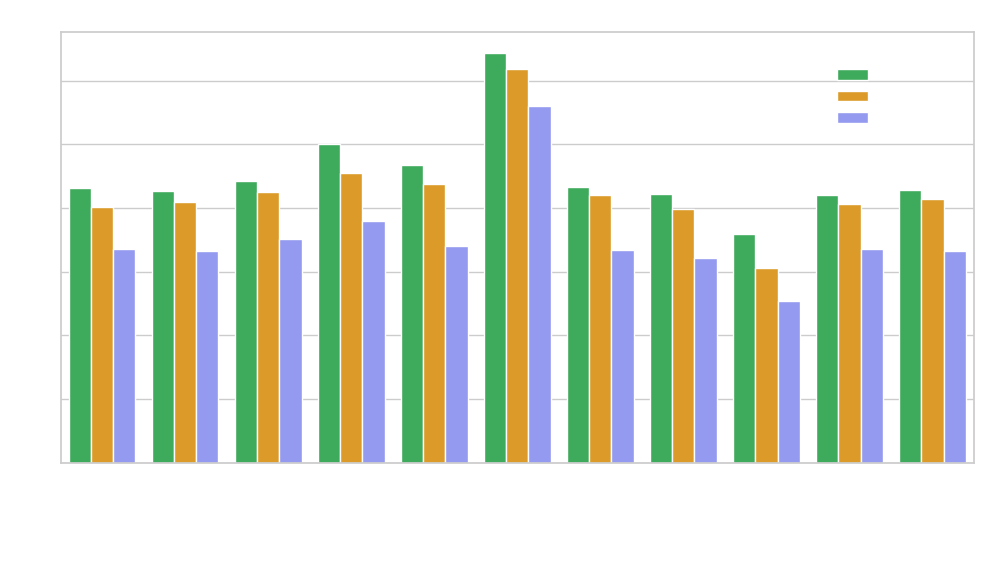

In [87]:
# calcular la edad media por job y estado civil 
age_job_marital = (
    bank_additional
    .groupby(['job', 'marital'])['age']
    .mean()
    .round(1)
    .reset_index()
)
age_job_marital.head()

# gráfico de barras
colors2 = {
    'MARRIED': '#FAA30A',
    'SINGLE':  '#858DFF',
    'DIVORCED': "#2bbc54"
}

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    data=age_job_marital,
    x='job',
    y='age',
    hue='marital',
    palette=colors2,
    ax=ax
)

ax.set_title('Edad media por profesión y estado civil', color='white', fontsize=14)
ax.set_xlabel('Profesión', color='white')
ax.set_ylabel('Edad media', color='white')

# Rotar etiquetas del eje X para que se lean mejor
plt.xticks(rotation=45, ha='right')

# Colores de los ejes en blanco (para fondo oscuro)
ax.tick_params(colors='white')
ax.yaxis.label.set_color('white')
ax.xaxis.label.set_color('white')

# Fondo transparente (para exportar a PPT)
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)

# Leyenda en blanco
legend = ax.legend(title='Estado civil', facecolor='none', edgecolor='none')
plt.setp(legend.get_title(), color='white')
for text in legend.get_texts():
    text.set_color('white')

plt.tight_layout()
plt.show()

fig.savefig(
    './datos_transformados/edad_media_job_marital.png',
    transparent=True,
    bbox_inches='tight',
    dpi=300
)

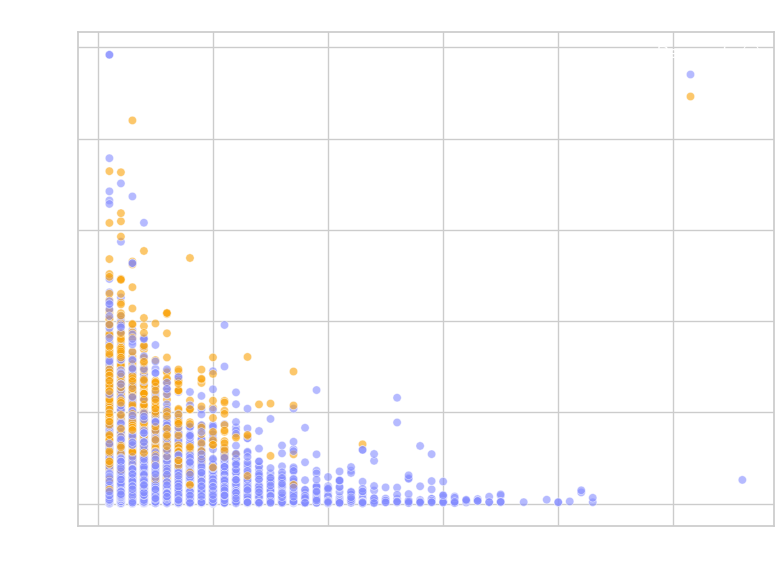

In [ ]:
# Relación de la duracion de la llamada y el número de veces contactado con la respuesta del cliente a los productos

fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(
    data=bank_additional,
    x='campaign',
    y='duration',
    hue='y',
    palette=colors,
    alpha=0.6,  # puntos semitransparentes
    ax=ax
)

ax.set_title('Duración vs número de contactos según respuesta del cliente', color='white', fontsize=14)
ax.set_xlabel('Número de contactos durante la campaña', color='white')
ax.set_ylabel('Duración de la llamada (segundos)', color='white')

ax.tick_params(colors='white')
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)

# Leyenda en blanco
legend = ax.legend(title='Respuesta (y)', facecolor='none', edgecolor='none')
plt.setp(legend.get_title(), color='white')
for text in legend.get_texts():
    text.set_color('white')

plt.tight_layout()
plt.show()

fig.savefig(
    './datos_transformados/contactos_vs_duracion_y.png',
    transparent=True,
    bbox_inches='tight',
    dpi=300
)

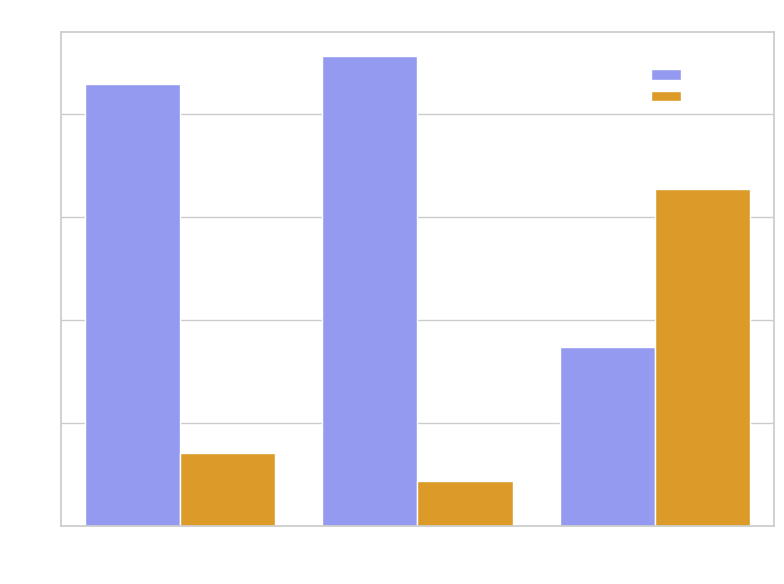

In [89]:
# ¿Clientes que ya contrataron son más receptivos a la nueva campaña?

# Calcula porcentaje de respuestas según resultado anterior
poutcome_conv = (
    bank_additional
    .groupby('poutcome')['y']
    .value_counts(normalize=True)
    .mul(100)
    .rename('percentage')
    .reset_index()
)

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=poutcome_conv,
    x='poutcome',
    y='percentage',
    hue='y',
    palette=colors,
    ax=ax
)

ax.set_title('Impacto de campañas previas sobre la respuesta actual', color='white', fontsize=14)
ax.set_xlabel('Resultado de la campaña previa (poutcome)', color='white')
ax.set_ylabel('Porcentaje de respuesta (%)', color='white')

ax.tick_params(colors='white')
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)

legend = ax.legend(title='Respuesta actual (y)', facecolor='none', edgecolor='none')
plt.setp(legend.get_title(), color='white')
for text in legend.get_texts():
    text.set_color('white')

plt.tight_layout()
plt.show()

fig.savefig(
    './datos_transformados/impacto_campanas_previas.png',
    transparent=True,
    bbox_inches='tight',
    dpi=300
)



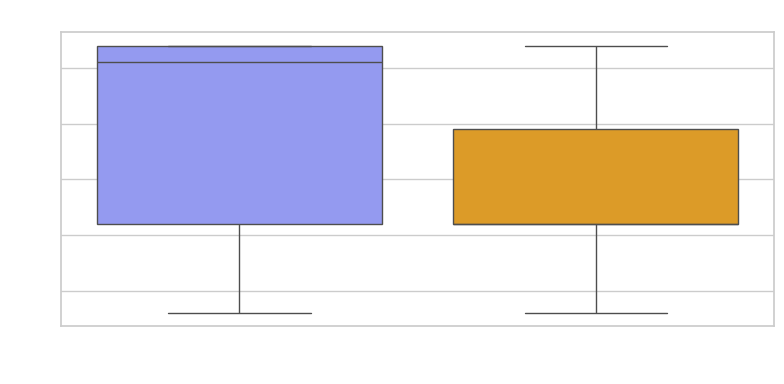

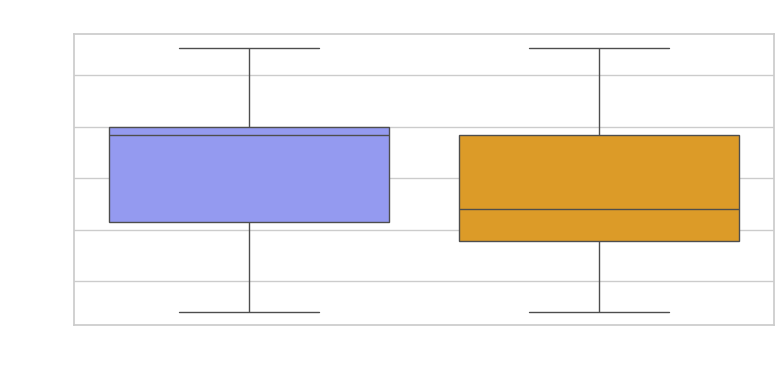

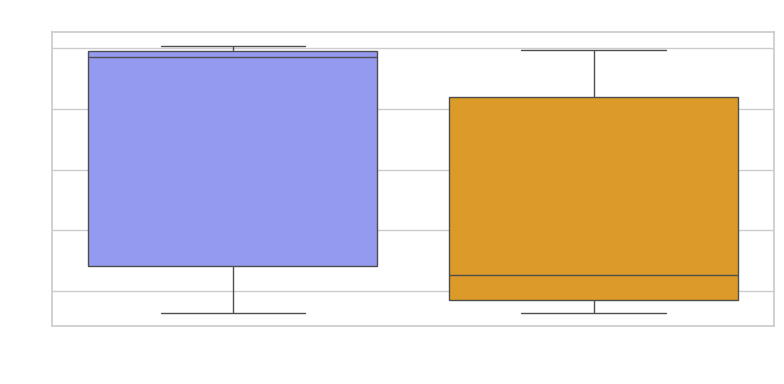

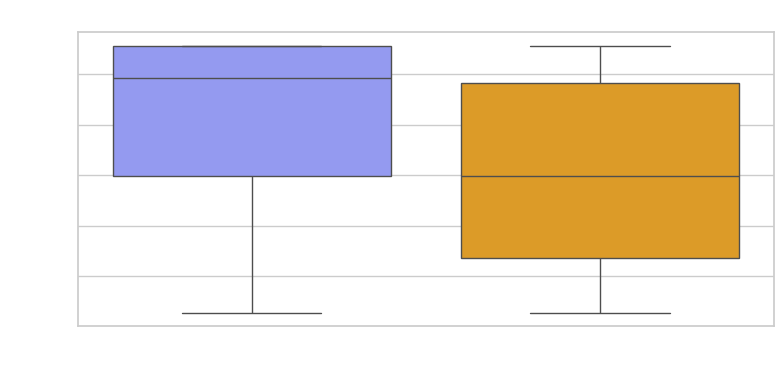

In [90]:
def estilo_grafico(col, title, ylabel, filename=None, white_text=True):
    fig, ax = plt.subplots(figsize=(8, 4))

    sns.boxplot(
        data=bank_additional,
        x='y',
        y=col,
        hue='y',
        palette=colors,
        dodge=False,
        legend=False,
        ax=ax
    )

    if white_text:
        txt_color = 'white'
    else:
        txt_color = 'black'

    ax.set_title(title, color=txt_color, fontsize=14)
    ax.set_xlabel('¿Contrató el producto?', color=txt_color)
    ax.set_ylabel(ylabel, color=txt_color)
    ax.tick_params(colors=txt_color)

    fig.patch.set_alpha(0.0)
    ax.patch.set_alpha(0.0)

    plt.tight_layout()
    plt.show()

    # Guarda si se pasa filename
    if filename is not None:
        fig.savefig(
            filename,
            transparent=True,
            bbox_inches='tight',
            dpi=300
        )


# Variables macroeconómicas vs
# Tasa de variación de empleo
estilo_grafico(
    col='emp.var.rate',
    title='Tasa de variación de empleo',
    ylabel='emp.var.rate',
    filename='./datos_transformados/tasa_variacion_empleo.png'
)

# Índice de precios al consumidor
estilo_grafico(
    col='cons.price.idx',
    title='Índice de precios al consumidor',
    ylabel='cons.price.idx',
    filename='./datos_transformados/indice_precios_consumidor.png'
)

# Tasa de euribor
estilo_grafico(
    col='euribor3m',
    title='Tasa Euribor (3 meses)',
    ylabel='euribor3m',
    filename='./datos_transformados/tasa_euribor.png'
)

# Número promedio de empleados (en el país)
estilo_grafico(
    col='nr.employed',
    title='Número promedio de empleados (en el país)',
    ylabel='nr.employed',
    filename='./datos_transformados/promedio_empleados.png'
)


/var/folders/0t/7q5wxs1s157_06nj_h8s16rw0000gp/T/ipykernel_49917/361695622.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/0t/7q5wxs1s157_06nj_h8s16rw0000gp/T/ipykernel_49917/361695622.py:22: UserWarning: 
The palette list has fewer values (1) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


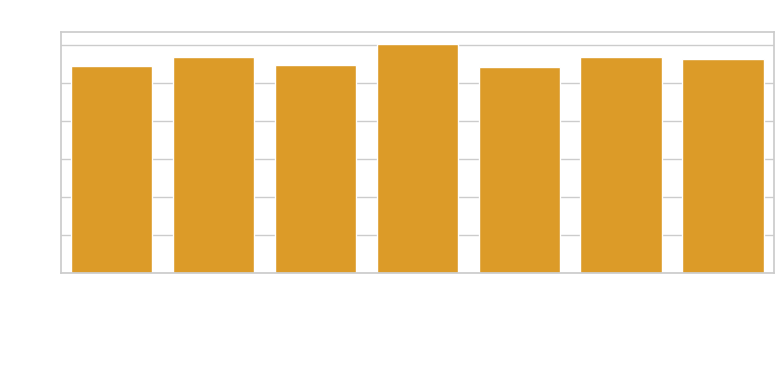

In [91]:
# Día de la semana vs % de “yes”
color = ['#FAA30A']

# Calcular % de “yes” por día
weekday_conv = (
    bank_additional
    .groupby('weekday')['y']
    .value_counts(normalize=True)
    .mul(100)
    .rename('percentage')
    .reset_index()
)

weekday_yes = weekday_conv[weekday_conv['y'] == 'yes']

# Orden lógico de los días
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# Crear figura y eje
fig, ax = plt.subplots(figsize=(8, 4))

sns.barplot(
    data=weekday_yes,
    x='weekday',
    y='percentage',
    order=order,
    palette=color,
    ax=ax
)

# Estilo coherente con tus otros gráficos
ax.set_title('Porcentaje de clientes que dijeron "yes" por día de la semana', color='white', fontsize=14)
ax.set_xlabel('Día de la semana', color='white')
ax.set_ylabel('% "yes"', color='white')
ax.tick_params(colors='white')

# Fondo transparente
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)

# Rotar etiquetas si hace falta
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

fig.savefig(
    './datos_transformados/yes_por_dia_semana.png',
    transparent=True,
    bbox_inches='tight',
    dpi=300
)

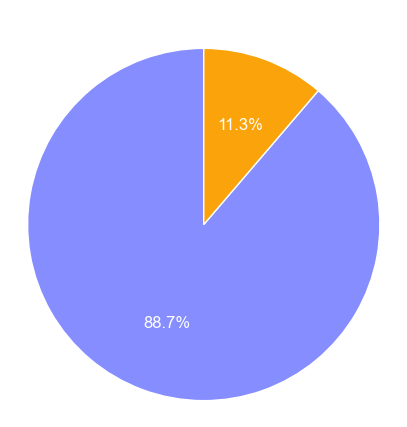

<Figure size 500x500 with 0 Axes>

In [94]:
y_counts = bank_additional['y'].value_counts()

colors = ['#858DFF','#FAA30A']
fig, ax = plt.subplots(figsize=(5, 5))
plt.figure(figsize=(5, 5))
ax.pie(
    y_counts, 
    labels=y_counts.index,          # ['no', 'yes']
    autopct='%1.1f%%',              # mostrar porcentaje con 1 decimal
    startangle=90,                  # que empiece arriba
    colors=colors,
    textprops={'color': 'white'}
)
ax.set_title('Distribución de respuestas (y)', color='white', fontsize=14)
ax.axis('equal')  # para que el círculo no salga ovalado
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)
plt.show()

fig.savefig(
    './datos_transformados/grafico1.png',
    transparent=True,
    bbox_inches='tight',
    dpi=300
)

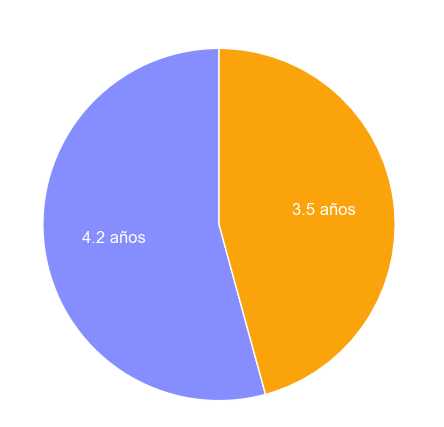

In [95]:
antig_media = (
    merged
    .groupby('y')['customer_years']
    .mean()
    .round(2)
)

fig, ax = plt.subplots(figsize=(5, 5))

ax.pie(
    antig_media,
    labels=antig_media.index,
    autopct=lambda p: f"{p*sum(antig_media)/100:.1f} años",
    startangle=90,
    colors=colors,
    textprops={'color': 'white'}
)

ax.set_title('Antigüedad media del cliente según respuesta', color='white', fontsize=14)
ax.axis('equal')

# Fondo transparente
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)

plt.show()

fig.savefig(
    './datos_transformados/antiguedad_media_cliente.png',
    transparent=True,
    bbox_inches='tight',
    dpi=300
)
